In [1]:
import numpy as np
from numpy.fft import rfft, irfft
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.signal import unit_impulse as delta
from scipy.optimize import minimize
import copy

In [2]:
def generate_signal(signal_len):
    part_len = round(signal_len / 6)
    last_part_len = signal_len - part_len * 5 + 1
    f = np.concatenate((
        np.zeros(part_len),
        np.ones(part_len),
        np.ones(part_len) * 0.5,
        np.linspace(0.5, 1, part_len),
        np.linspace(1, 0, part_len),
        np.zeros(last_part_len)
    ))
    #x = np.arange(0, 300)
    #f = np.abs(np.arcsin(np.sin(x/30)))
    #f[96:150] = 0
    #f[140:200] = 0.8
    #f[200:225] = np.linspace(0.8, 0, 25)
    #f[225:250] = np.linspace(0, 0.8, 25)
    #f[250:280] = 1.6
    return f

def generate_uniform_kernel(signal_len, s):     #kernel_fun
    d = 2 * np.sqrt(3.) * s
    a = np.zeros(signal_len)
    a[: int(round(d / 2))] = 1
    a[-int(round(d / 2)):] = 1
    a = a / a.sum()
    return a

In [3]:
signal_len = 300
kernel_fun = generate_uniform_kernel
nsr = 0  # noise/signal rate
threshold = 1e-3  # to split \Omega into \Omega_1 and \Omega_2

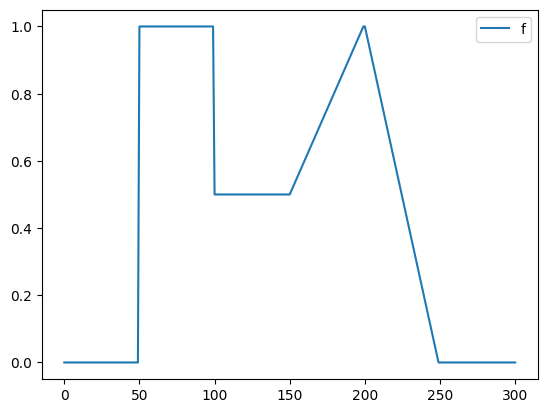

In [4]:
#Actual thing, that we want to measure

f = generate_signal(signal_len)
FT_f = rfft(f)
plt.plot(f)
plt.legend("f")

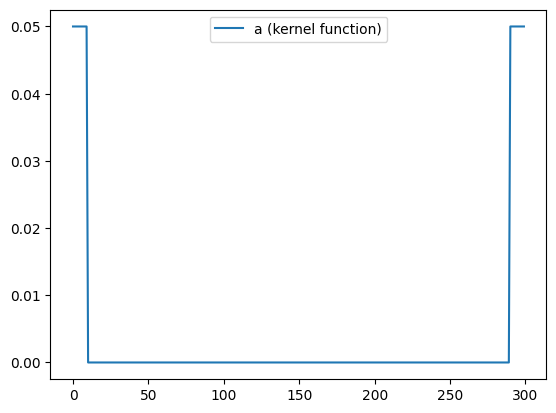

In [5]:
#Generate uniform kernel function

a = kernel_fun(signal_len, signal_len / 50)
FT_a = rfft(a)
q = FT_a.shape[0]   #q = 151
plt.plot(a)
plt.legend(("a (kernel function)", ""))

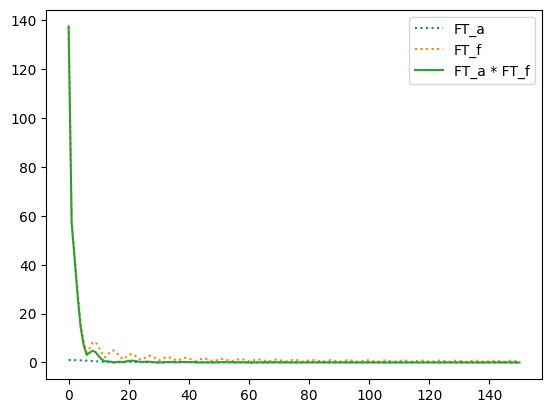

In [6]:
#Generating Measuring function

FT_Af = FT_a * FT_f
Af = irfft(FT_Af)
plt.plot(np.abs(FT_a), linestyle=':')
plt.plot(np.abs(FT_f), linestyle=':')
plt.plot(np.abs(FT_a)*np.abs(FT_f))
plt.legend(("FT_a", "FT_f", "FT_a * FT_f"))

In [7]:
#Generating random noise

nu = nsr * np.random.normal(size=Af.shape)      

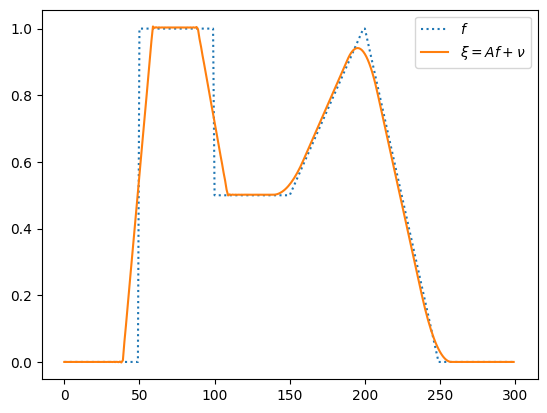

In [8]:
#Completing instrument function (метод скользящего среднего)

xi = Af + nu        
FT_xi = rfft(xi)
plt.plot(f, linestyle=':')
plt.plot(xi)
plt.legend(("$f$", "$\\xi = Af + \\nu$"))

In [9]:
FT_a1 = np.zeros(q, dtype=np.complex64)
FT_a1pinv = np.zeros(q, dtype=np.complex64)
FT_f2 = np.zeros(q, dtype=np.complex64)
w = []  #indeces for "cutted off" frequences
k = 0

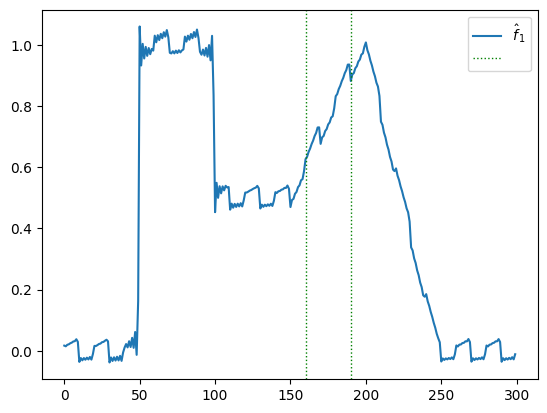

In [10]:
#First enhancement step

for i in range(q):
    if np.abs(FT_a[i]) < threshold:
        k += 1
        w.append(i)  # "cut off" these freqs
        FT_f2[i] = FT_f[i]
    else:
        FT_a1[i] = FT_a[i]
        FT_a1pinv[i] = 1. / FT_a[i]
fhat1 = irfft(FT_a1pinv * FT_xi)
plt.plot(fhat1)
plt.axvline(x=160, ymin=0.0, ymax=1.0, color='g', linestyle=':', linewidth=1)
plt.axvline(x=190, ymin=0.0, ymax=1.0, color='g', linestyle=':', linewidth=1)
plt.legend(("$\hat f_1$", ""))

In [11]:
init_coord = 160
final_coord = 203

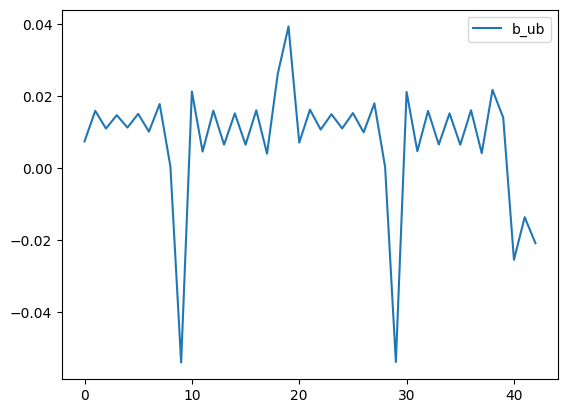

In [12]:
#Trying to step-enhance by XLR-cable principle, b_ub will be used in scipy.optimize.linprog in the future

b_ub = fhat1[init_coord+1: final_coord+1] - fhat1[init_coord: final_coord]
plt.plot(b_ub)
plt.legend(("b_ub", ""))

[15, 30, 45, 60, 75, 90, 105, 120, 135, 150]

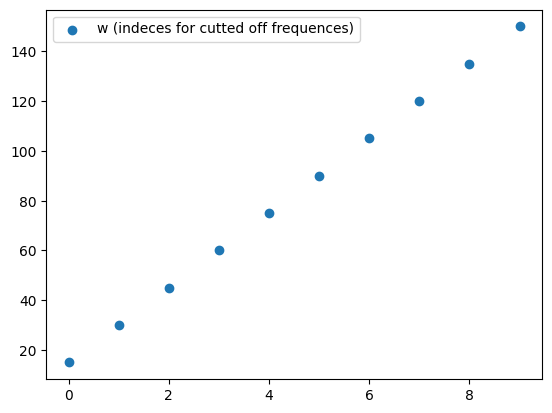

In [13]:
vec_len = 2*len(w) + 1
A_ub = np.ones((final_coord-init_coord, vec_len))   #43 by 21 matrix
plt.scatter(np.arange(0, len(w)), w)
plt.legend(("w (indeces for cutted off frequences)", ""))
w

In [14]:
#Calculating A_ub for using in scipy.optimize.linprog

for i in range(init_coord, final_coord):
    for j in range(len(w)):
        A_ub[i-init_coord, j+1]          =   irfft(   delta(q, w[j]))[i]   -   irfft(   delta(q, w[j]))[i+1]
        A_ub[i-init_coord, j+1+len(w)]   =   irfft(1j*delta(q, w[j]))[i]   -   irfft(1j*delta(q, w[j]))[i+1]
range(len(w))

range(0, 10)

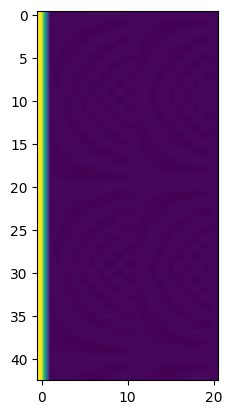

In [15]:
c = np.zeros((vec_len))
c[0] = -1   # instead of minimize we will maximize
bound = 2 * np.abs(FT_a1pinv*FT_xi).max()
plt.imshow(A_ub, interpolation='bilinear')

In [16]:
#minimize a linear objective function subject to linear equality and inequality constraints using scipy.optimize.linprog

res = scipy.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=((-bound, bound)), options={"disp": True})
#res     #res.x[0] = 0.0040245362510518135

Running HiGHS 1.2.0 [date: 2021-07-09, git hash: n/a]
Copyright (c) 2022 ERGO-Code under MIT licence terms
Presolving model
43 rows, 20 cols, 824 nonzeros
20 rows, 20 cols, 384 nonzeros
20 rows, 20 cols, 384 nonzeros
Presolve : Reductions: rows 20(-23); columns 20(-1); elements 384(-440)
Solving the presolved LP
Using EKK dual simplex solver - serial
  Iteration        Objective     Infeasibilities num(sum)
          0    -2.7500045033e+02 Pr: 20(4947.26) 0s
         25    -4.0430247986e-03 Pr: 0(0) 0s
Solving the original LP from the solution after postsolve
Model   status      : Optimal
Simplex   iterations: 25
Objective value     : -4.0430247986e-03
HiGHS run time      :          0.02


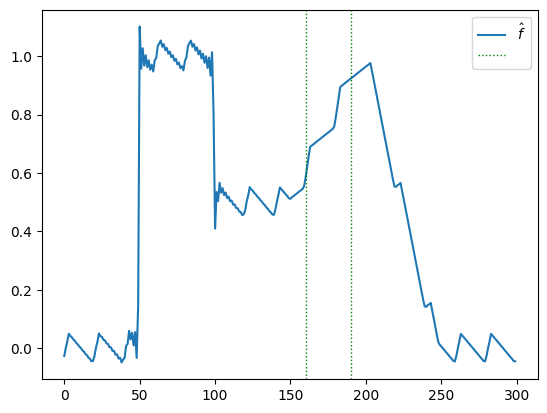

In [17]:
fhat2 = np.zeros(fhat1.shape[0])
for j in range(len(w)):
    fhat2 += res.x[j+1] * irfft(delta(q, w[j])) + res.x[j+1+len(w)] * irfft(1j*delta(q, w[j]))
fhat = fhat1 + fhat2
plt.plot(fhat)
plt.axvline(x=160, ymin=0.0, ymax=1.0, color='g', linestyle=':', linewidth=1)
plt.axvline(x=190, ymin=0.0, ymax=1.0, color='g', linestyle=':', linewidth=1)
plt.legend(("$\hat f$", ""))

###################################################
# Enhancing
###################################################

In [18]:
res_better = copy.deepcopy(res)
threshold_z = res.x[0]
new_threshold = threshold_z
A_ub_better = A_ub.copy()
b_ub_better = b_ub.copy()
fhat_better = fhat.copy()
iter_points = np.arange(init_coord, final_coord)
better = False
threshold_point = -1
num_iter = 1
res_better

        message: Optimization terminated successfully. (HiGHS Status 7: Optimal)
        success: True
         status: 0
            fun: -0.004043024798624318
              x: [ 4.043e-03 -2.202e+00 ... -4.492e-01 -2.750e+02]
            nit: 25
          lower:  residual: [ 2.750e+02  2.728e+02 ...  2.746e+02
                              0.000e+00]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          upper:  residual: [ 2.750e+02  2.772e+02 ...  2.754e+02
                              5.500e+02]
                 marginals: [ 0.000e+00  0.000e+00 ...  0.000e+00
                              0.000e+00]
          eqlin:  residual: []
                 marginals: []
        ineqlin:  residual: [ 3.286e-02  2.952e-02 ...  0.000e+00
                              0.000e+00]
                 marginals: [-0.000e+00 -0.000e+00 ... -5.000e-02
                             -5.000e-02]
 mip_node_count: 0
 mip_dual_bound: 0.0
        

In [19]:
for iter in range(num_iter):
    threshold_point = -1    
    for i in iter_points:
        if i == -1:
            continue
        A_ub_prev = A_ub_better.copy()
        b_ub_prev = b_ub_better.copy()
        res_prev = copy.deepcopy(res_better)

        if (fhat_better[i+1] - fhat_better[i]) <= threshold_z + 1e-3:   #1e-5
            A_ub_better[i - init_coord, 0] = 0
            b_ub_better[i - init_coord] += -threshold_z + 1
            res_better = scipy.optimize.linprog(c, A_ub=A_ub_better, b_ub=b_ub_better, bounds=((-bound, bound)))
            print(f"old z = {str(new_threshold)} new z = {str(res_better.x[0])}")

            if res_better.x[0] >= new_threshold + 1e-3:
                new_threshold = res_better.x[0]
                threshold_point = i
                print(f"Новое значение z = {str(new_threshold)}")
                print(f"Улучшение в точке {str(threshold_point)}")
        
                threshold_z = new_threshold
                iter_points[np.where(iter_points == threshold_point)] = -1
                fhat2_better = np.zeros(fhat1.shape[0])

                for j in range(len(w)):
                    fhat2_better += res_better.x[j+1] * irfft(delta(q, w[j]))   +   res_better.x[j+1+len(w)] * irfft(1j*delta(q, w[j]))
                
                fhat_better = fhat1 + fhat2_better
                print(f"New diff in the selected point = {fhat_better[i + 1] - fhat_better[i]}")
                other_points = np.hstack((np.arange(init_coord, i), np.arange(i + 1, final_coord)))
                print(f"New min diff in other points = {np.min(fhat_better[other_points + 1] - fhat_better[other_points])}")
                better = True
            else:
                A_ub_better = A_ub_prev.copy()
                b_ub_better = b_ub_prev.copy()
                res_better = copy.deepcopy(res_prev)
    if threshold_point == -1:
        print("Нет точек для улучшения")

old z = 0.004043024798624318 new z = 0.004056152191531083
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.0040540323269025996
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004051995030229226
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004049909945131876
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.00404761153448111
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004044874877064889
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004044777474824279
old z = 0.004043024798624318 new z = 0.004050228877009916
old z = 0.004043024798624318 new z = 0.004043024798624318
old z = 0.004043024798624318 new z = 0.004055073814202424
old z = 0.0040

###################################################
# Calculate fhat2 and combine it with fhat1
###################################################

In [20]:
fhat2 = np.zeros(fhat1.shape[0])
for j in range(len(w)):
    fhat2 += res.x[j+1] * irfft(delta(q, w[j]))   +   res.x[j+1+len(w)] * irfft(1j*delta(q, w[j]))
fhat = fhat1 + fhat2
#if False:  # better:
if True:
    fhat2_better = np.zeros(fhat1.shape[0])
    for j in range(len(w)):
        fhat2_better += res_better.x[j+1] * irfft(delta(q, w[j]))   +   res_better.x[j+1+len(w)] * irfft(1j*delta(q, w[j]))
    fhat_better = fhat1 + fhat2_better


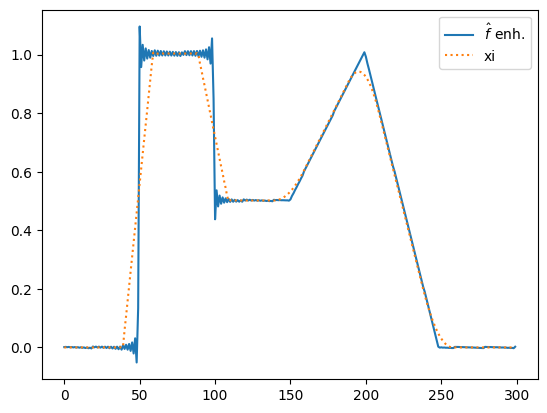

In [21]:
#plt.plot(fhat1, "red")
#plt.plot(fhat, "blue")
plt.plot(fhat_better)
plt.plot(xi, linestyle=':')
plt.legend(("$\hat f$ enh.", "xi"))

fh_better ничем не отличается от fhat
